In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
sujets = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
times = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [3]:
with open('data/enregistrement_%s_%s.pkl'%(sujets[0], times[0]), 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
datafile = 'data/enregistrement_%s_%s.asc'%(sujets[0], times[0])

In [4]:
def moulti_fit(sujet, trial, nb_fit=25, perturbation=200):
    with open('data/enregistrement_%s_%s.pkl'%(sujets[sujet], times[sujet]), 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
    datafile = 'data/enregistrement_%s_%s.asc'%(sujets[sujet], times[sujet])

    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    data_full = read_edf(datafile, 'TRIALID')

    Plot.plot_fit(data_full, trials=trial, fig_width=30)

    arg = A.arg(data_full[trial], trial=trial, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti, **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] :
        result_full_data[k] = result_full_data[k] - (arg.TargetOn-arg.t_0)
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    #color = 'g'
    result_red_data = []
    
    step = 2
    #i=0
    
    for color, i in zip(['g', 'b'], [0,1]) :
        
        
        data_red = read_edf(datafile, 'TRIALID')
        for var in data_red[trial].keys() :
            if var != 'events' :
                data_red[t][var] = np.array([data_red[trial][var][x] for x in range(i, len(data_red[trial][var]), step)])        
        arg_red = A.arg(data_red[trial], trial=trial, block=0)

        #-------------------------------------------------------------------------------
        max_latency = len(arg.trackertime[:-int(280/step)])


        a = easydict.EasyDict()
        for v in ['StimulusOn', 'StimulusOf', 'TargetOn', 'TargetOff','t_0']:
            a[v] = int(arg_red[v]/step)
        
        #-------------------------------------------------------------------------------
        veve = [velocity[t] for t in np.arange(i, len(velocity), step)]
        value_latency = A.classical_method.latency(veve)
        value_anti = np.nanmean(veve[(a.TargetOn-a.t_0)-int(50/step):(a.TargetOn-a.t_0)+int(50/step)])
        value_steady_state = abs(np.nanmean(veve[(a.TargetOn-a.t_0)+int(400/step):(a.TargetOn-a.t_0)+int(600/step)]))

        if value_latency >= max_latency-(50/step) : value_latency = max_latency-(150/step)
        if value_latency > (250/step) :             value_latency = a.TargetOn-a.t_0+(100/step)
        if np.isnan(value_latency) :                value_latency = a.TargetOn-a.t_0+(100/step)


        #-------------------------------------------------------------------------------
        np.random.seed(10)
        list_latency = value_latency + perturbation*np.random.rand(nb_fit)*np.random.choice([-1,1], nb_fit)
        print(list_latency)


        #-------------------------------------------------------------------------------
        for lat in list_latency :

            param_fit=[{'name':'steady_state', 'value':value_steady_state, 'min':5., 'max':40., 'vary':True},
                       {'name':'dir_target',   'value':arg_red.dir_target, 'min':None, 'max':None, 'vary':False},
                       {'name':'a_anti',       'value':lat*step, 'min':-40.*step, 'max':40.*step, 'vary':True},
                       {'name':'latency',      'value':value_latency,
                          'min':a.TargetOn-a.t_0+(75/step), 'max':max_latency, 'vary':True},
                       {'name':'start_anti',   'value':a.TargetOn-a.t_0-(100/step),
                          'min':a.StimulusOf-a.t_0-(200/step), 'max':a.TargetOn-a.t_0+(75/step), 'vary':'vary'},
                       {'name':'tau',  'value':15., 'min':13., 'max':80., 'vary':'vary'}]

            inde_vars={'x':np.arange(len(arg_red.trackertime[:-int(280/step)]))}

            #===================================================================
            rere = Fit.Fit_trial(veve, param_fit=param_fit, inde_vars=inde_vars, time_sup=int(280/step))
            result_red = rere.values
            result_red['a_anti'] = result_red['a_anti']/step
            for k in ['latency', 'start_anti'] :
                result_red[k] = result_red[k]*step

            fit = A.Equation.fct_velocity(arg.trackertime[:-280]-arg.t_0, **result_red)
            plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, c=color)

            for k in ['latency', 'start_anti'] : result_red[k] = result_red[k] - (arg.TargetOn-arg.t_0)
            result_red_data.append(result_red)

    return(result_full_data, result_red_data)

In [5]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    
    x_range = {'steady_state': [ 5,  40], 'a_anti':     [ -40, 40],
               'latency':      [75, 500], 'start_anti': [-500, 75],
               'tau':          [13,  80]}
    
    list_, list_var = result_full_data_[0].keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(list_var)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                result_v.append(result_red_data[n][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r], fontsize=20)
            
            ax[nb_var][r].text(x_range[v][1]-(x_range[v][1]-x_range[v][0])/50,
                               np.max(hi[0])-np.max(hi[0])/50,
                               'true: %.1f\nmean: %.1f +/- %.1f'%(result_full_data[v], np.mean(result_v), np.std(result_v)),
                               ha='right', va='top', fontsize=20)
    plt.tight_layout()

# Good

AM
[303.73587135 462.15038987 584.72964699 607.76077651 358.29859754
 502.95932911 418.38742705 610.10614244 491.82216731 440.33203717
 595.07196367 267.32133076 457.21034673 560.43845268 295.47580767
 335.49478663 313.64893651 516.37521363 641.5548245  315.08484332
 349.4911264  429.56599048 532.66815201 323.17327699 546.36663488]
[302.73587135 461.15038987 583.72964699 606.76077651 357.29859754
 501.95932911 417.38742705 609.10614244 490.82216731 439.33203717
 594.07196367 266.32133076 456.21034673 559.43845268 294.47580767
 334.49478663 312.64893651 515.37521363 640.5548245  314.08484332
 348.4911264  428.56599048 531.66815201 322.17327699 545.36663488]


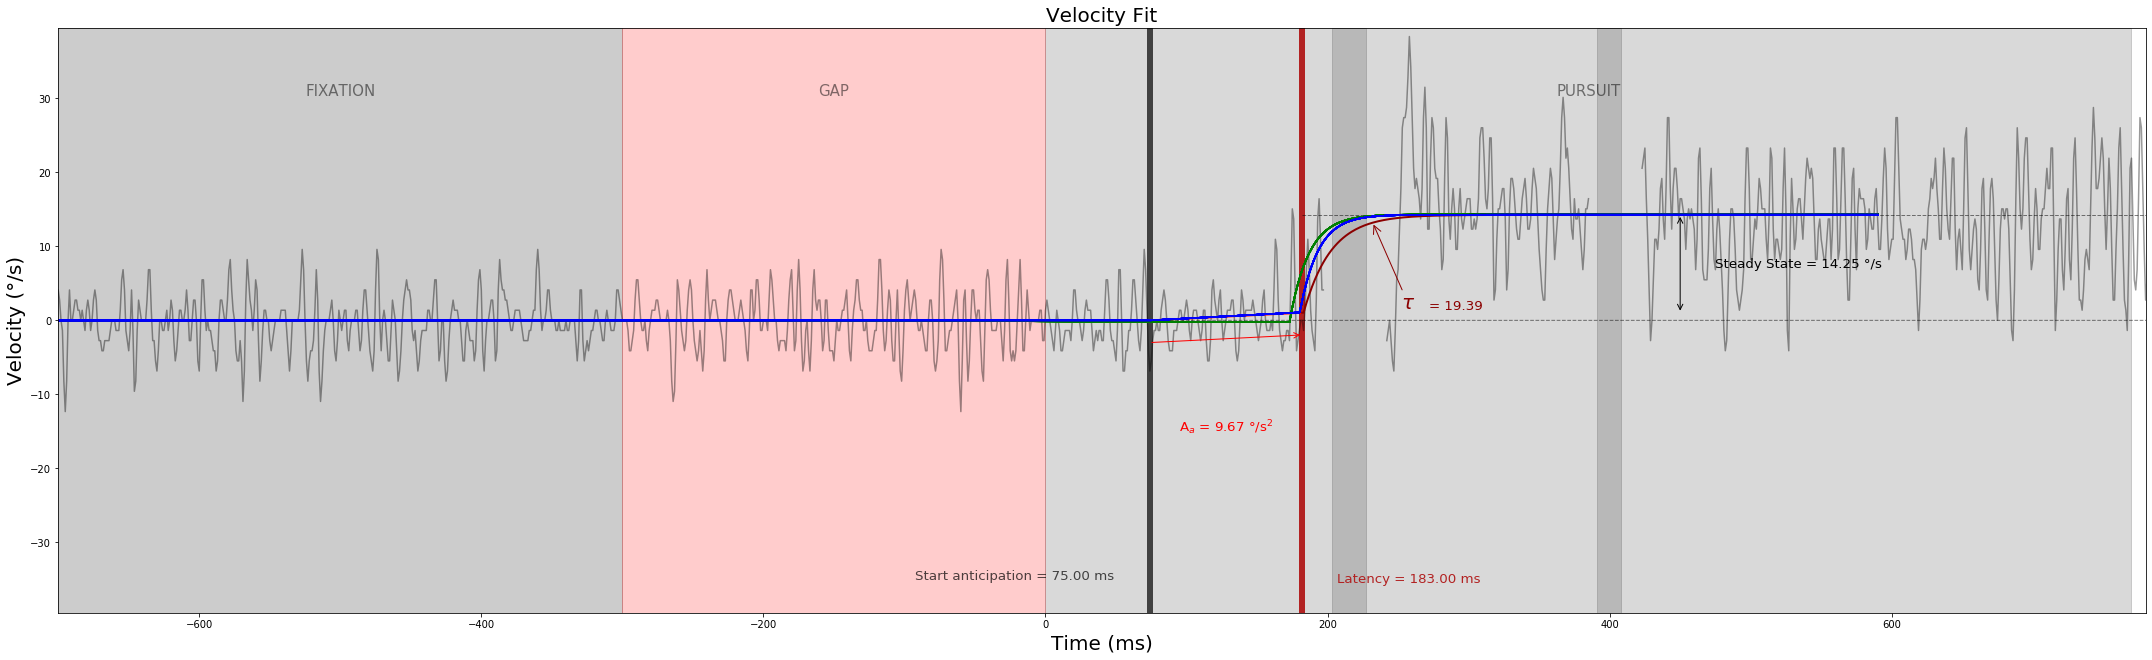

In [6]:
s, t = 0, 11
print(sujets[s])
result_full_data_s0, result_red_data_s0 = moulti_fit(s, t)

CS
[287.73587135 446.15038987 568.72964699 591.76077651 342.29859754
 486.95932911 402.38742705 594.10614244 475.82216731 424.33203717
 579.07196367 251.32133076 441.21034673 544.43845268 279.47580767
 319.49478663 297.64893651 500.37521363 625.5548245  299.08484332
 333.4911264  413.56599048 516.66815201 307.17327699 530.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

[287.73587135 446.15038987 568.72964699 591.76077651 342.29859754
 486.95932911 402.38742705 594.10614244 475.82216731 424.33203717
 579.07196367 251.32133076 441.21034673 544.43845268 279.47580767
 319.49478663 297.64893651 500.37521363 625.5548245  299.08484332
 333.4911264  413.56599048 516.66815201 307.17327699 530.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

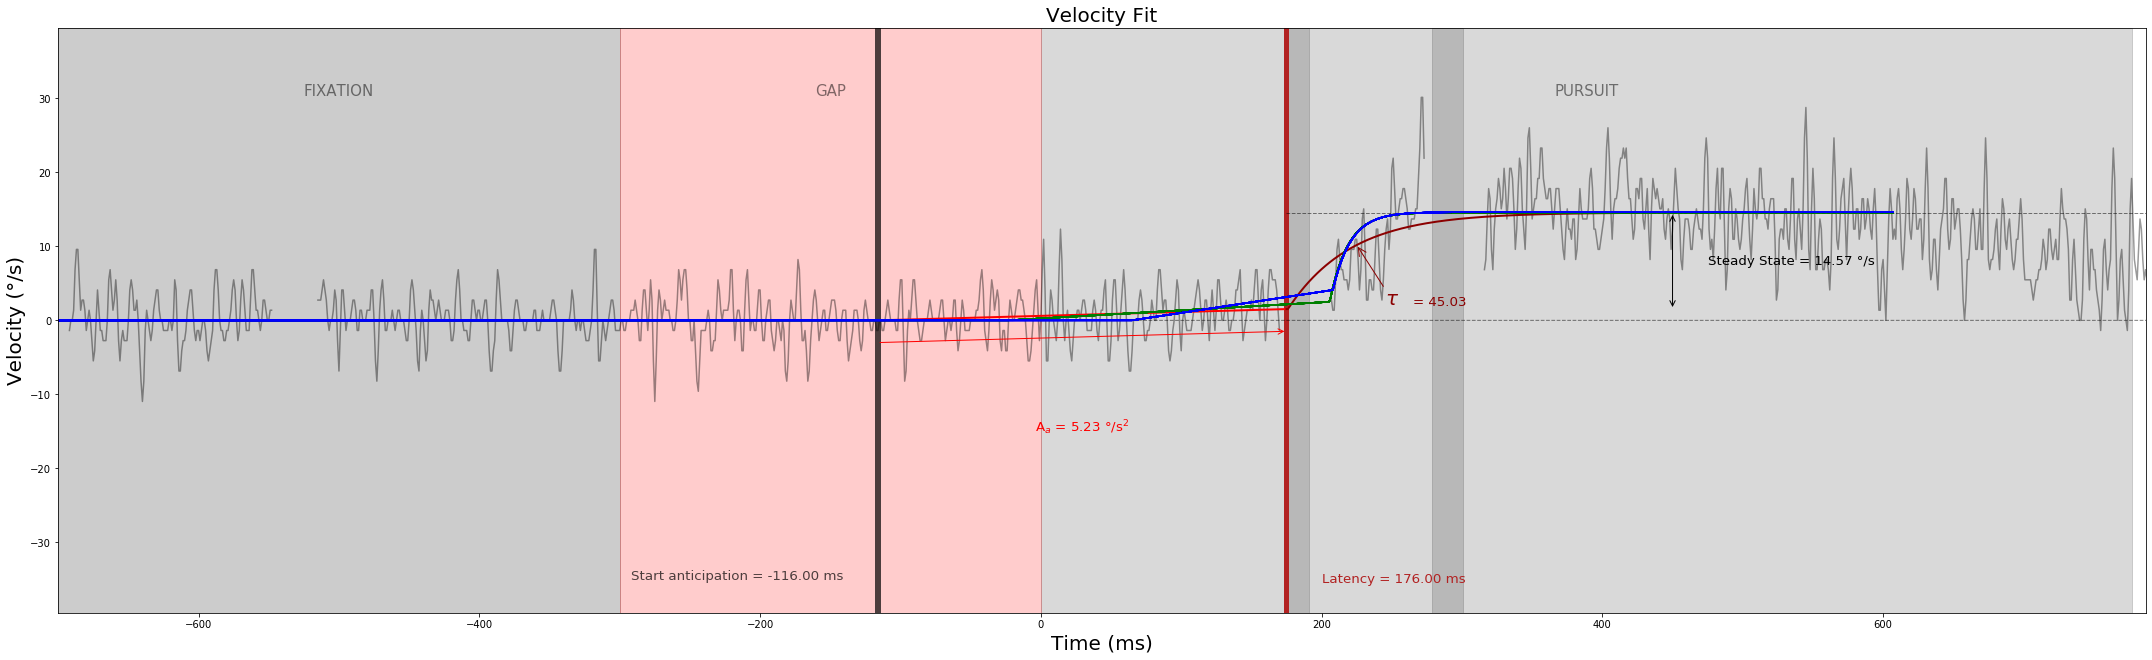

In [7]:
s, t = 2, 11
print(sujets[s])
result_full_data_s2, result_red_data_s2 = moulti_fit(s, t)

DC
[296.73587135 455.15038987 577.72964699 600.76077651 351.29859754
 495.95932911 411.38742705 603.10614244 484.82216731 433.33203717
 588.07196367 260.32133076 450.21034673 553.43845268 288.47580767
 328.49478663 306.64893651 509.37521363 634.5548245  308.08484332
 342.4911264  422.56599048 525.66815201 316.17327699 539.36663488]
[296.73587135 455.15038987 577.72964699 600.76077651 351.29859754
 495.95932911 411.38742705 603.10614244 484.82216731 433.33203717
 588.07196367 260.32133076 450.21034673 553.43845268 288.47580767
 328.49478663 306.64893651 509.37521363 634.5548245  308.08484332
 342.4911264  422.56599048 525.66815201 316.17327699 539.36663488]


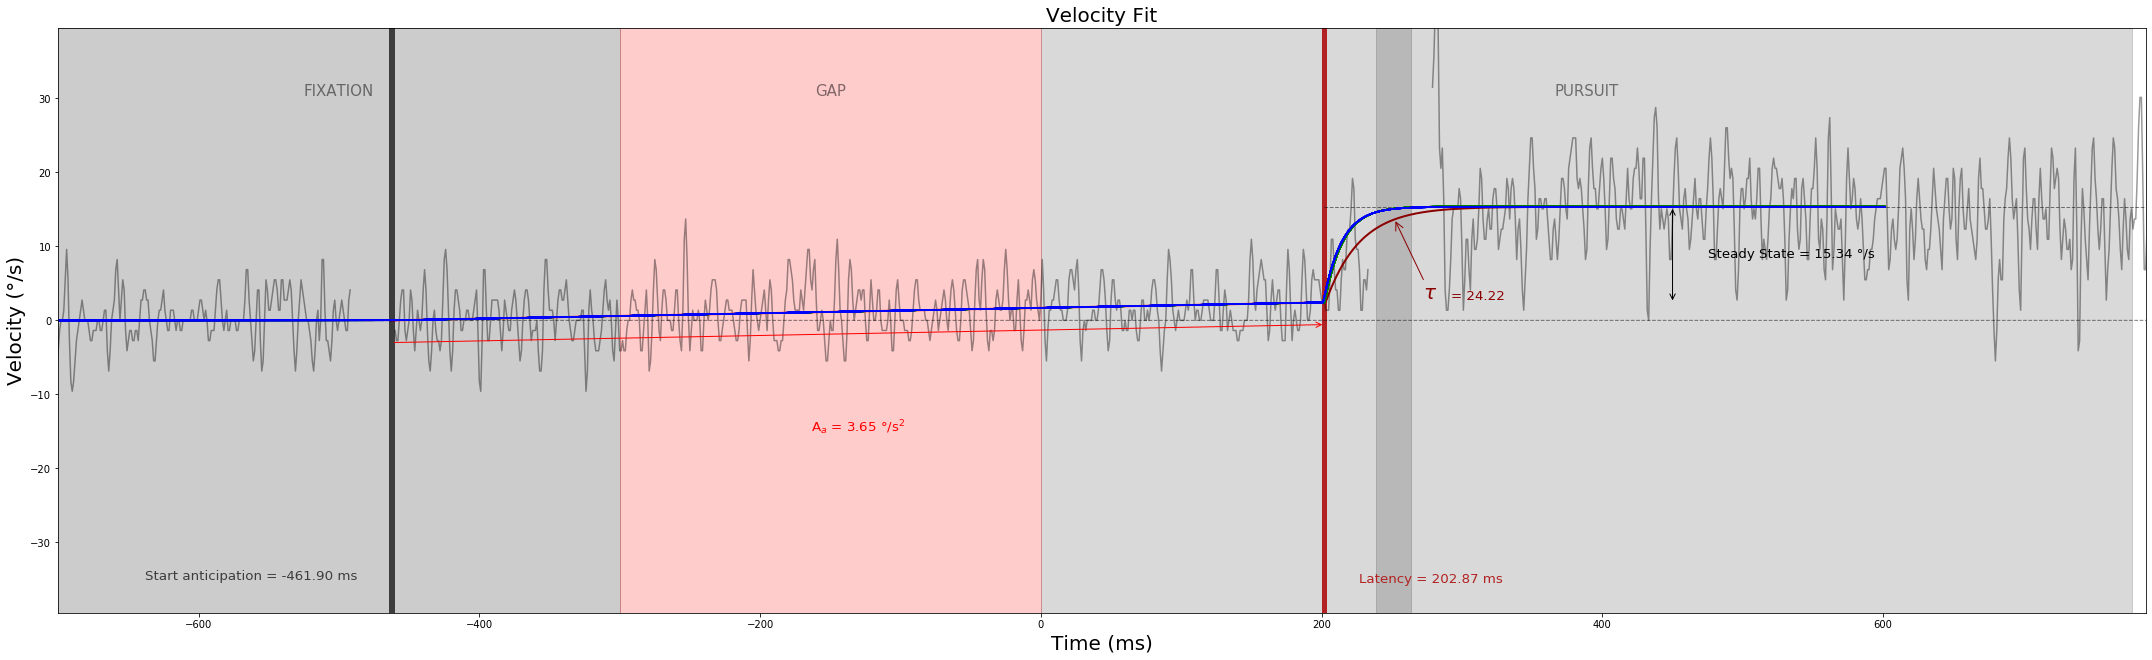

In [8]:
s, t = 3, 11
print(sujets[s])
result_full_data_s3, result_red_data_s3 = moulti_fit(s, t)

IP
[288.73587135 447.15038987 569.72964699 592.76077651 343.29859754
 487.95932911 403.38742705 595.10614244 476.82216731 425.33203717
 580.07196367 252.32133076 442.21034673 545.43845268 280.47580767
 320.49478663 298.64893651 501.37521363 626.5548245  300.08484332
 334.4911264  414.56599048 517.66815201 308.17327699 531.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

[288.73587135 447.15038987 569.72964699 592.76077651 343.29859754
 487.95932911 403.38742705 595.10614244 476.82216731 425.33203717
 580.07196367 252.32133076 442.21034673 545.43845268 280.47580767
 320.49478663 298.64893651 501.37521363 626.5548245  300.08484332
 334.4911264  414.56599048 517.66815201 308.17327699 531.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

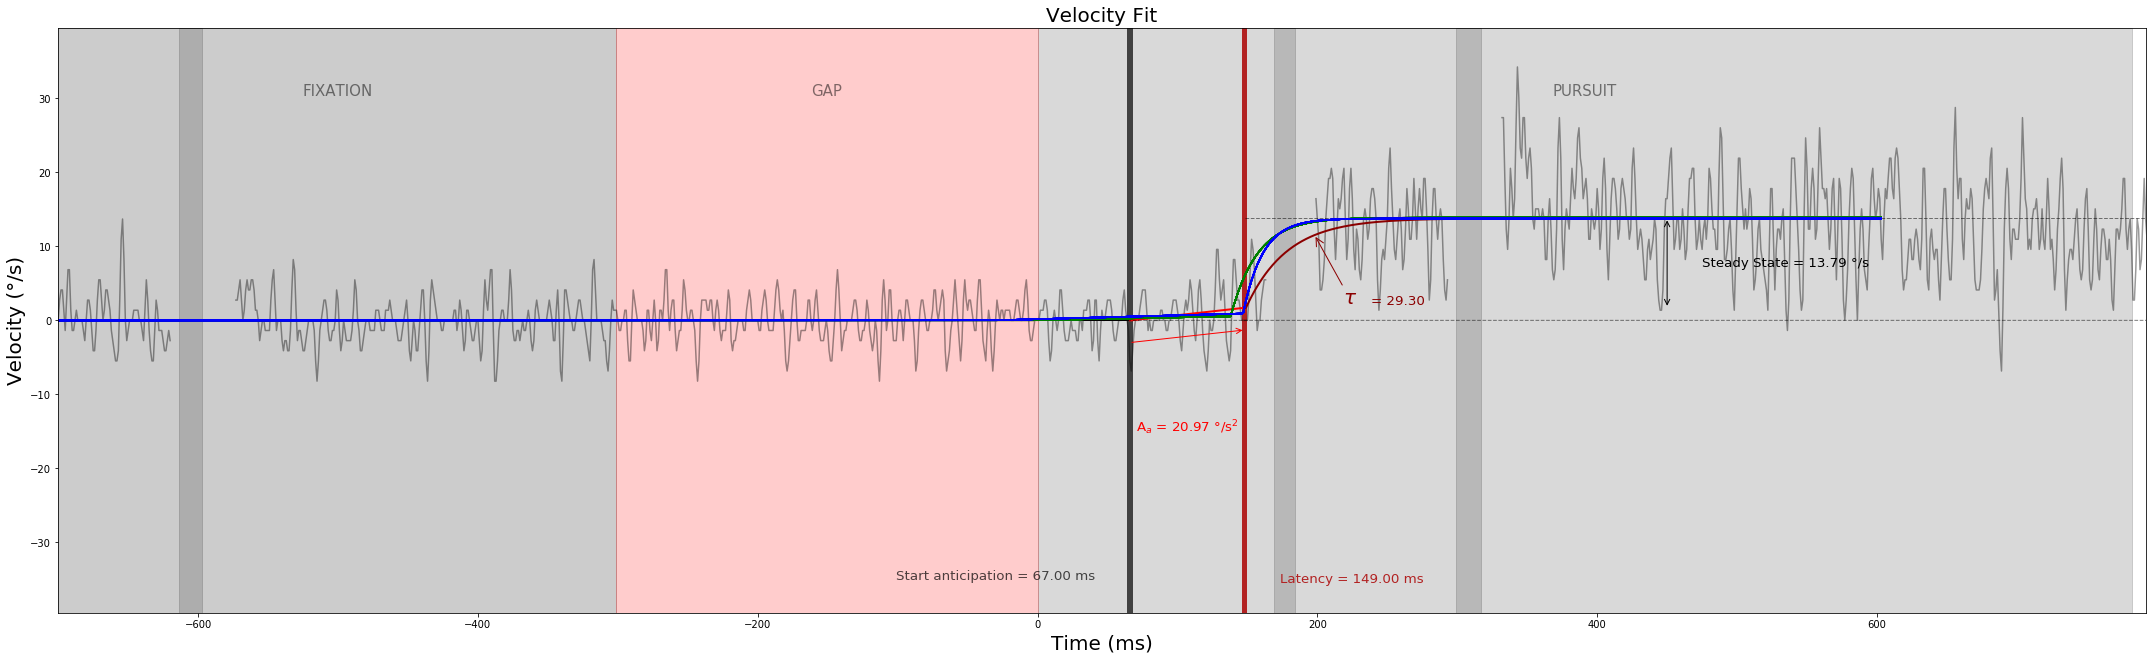

In [9]:
s, t = 5, 11
print(sujets[s])
result_full_data_s5, result_red_data_s5 = moulti_fit(s, t)

# Bad

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


[453.73587135 612.15038987 734.72964699 757.76077651 508.29859754
 652.95932911 568.38742705 760.10614244 641.82216731 590.33203717
 745.07196367 417.32133076 607.21034673 710.43845268 445.47580767
 485.49478663 463.64893651 666.37521363 791.5548245  465.08484332
 499.4911264  579.56599048 682.66815201 473.17327699 696.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

[453.73587135 612.15038987 734.72964699 757.76077651 508.29859754
 652.95932911 568.38742705 760.10614244 641.82216731 590.33203717
 745.07196367 417.32133076 607.21034673 710.43845268 445.47580767
 485.49478663 463.64893651 666.37521363 791.5548245  465.08484332
 499.4911264  579.56599048 682.66815201 473.17327699 696.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

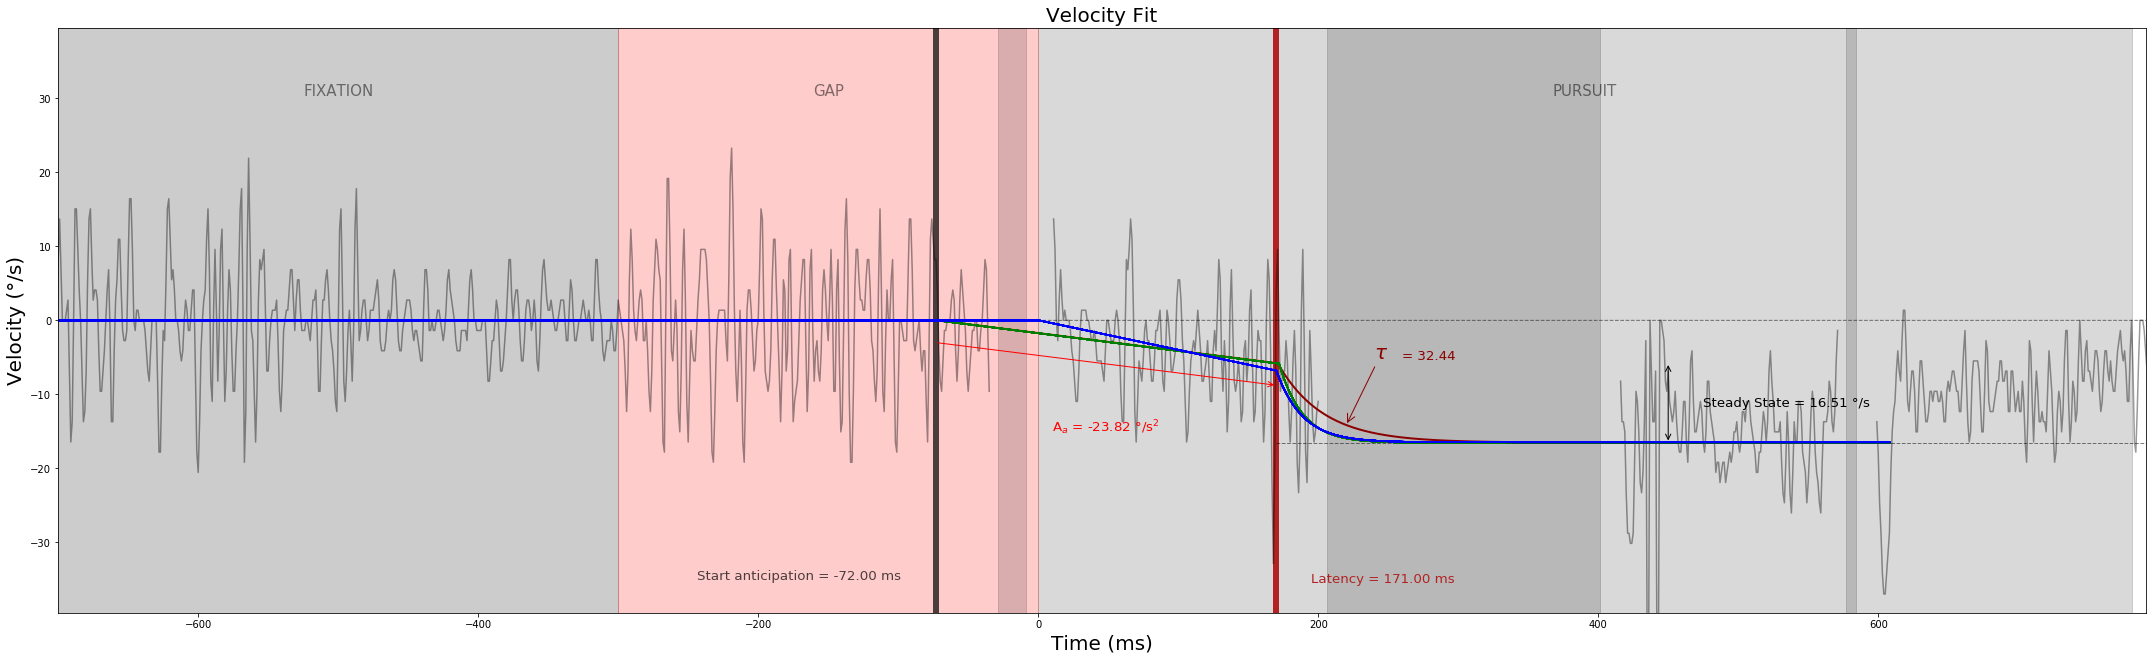

In [10]:
s, t = 11, 58
print(sujets[s])
result_full_data_s11_58, result_red_data_s11_58 = moulti_fit(s, t)

YK
[415.73587135 574.15038987 696.72964699 719.76077651 470.29859754
 614.95932911 530.38742705 722.10614244 603.82216731 552.33203717
 707.07196367 379.32133076 569.21034673 672.43845268 407.47580767
 447.49478663 425.64893651 628.37521363 753.5548245  427.08484332
 461.4911264  541.56599048 644.66815201 435.17327699 658.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/lo

[415.73587135 574.15038987 696.72964699 719.76077651 470.29859754
 614.95932911 530.38742705 722.10614244 603.82216731 552.33203717
 707.07196367 379.32133076 569.21034673 672.43845268 407.47580767
 447.49478663 425.64893651 628.37521363 753.5548245  427.08484332
 461.4911264  541.56599048 644.66815201 435.17327699 658.36663488]


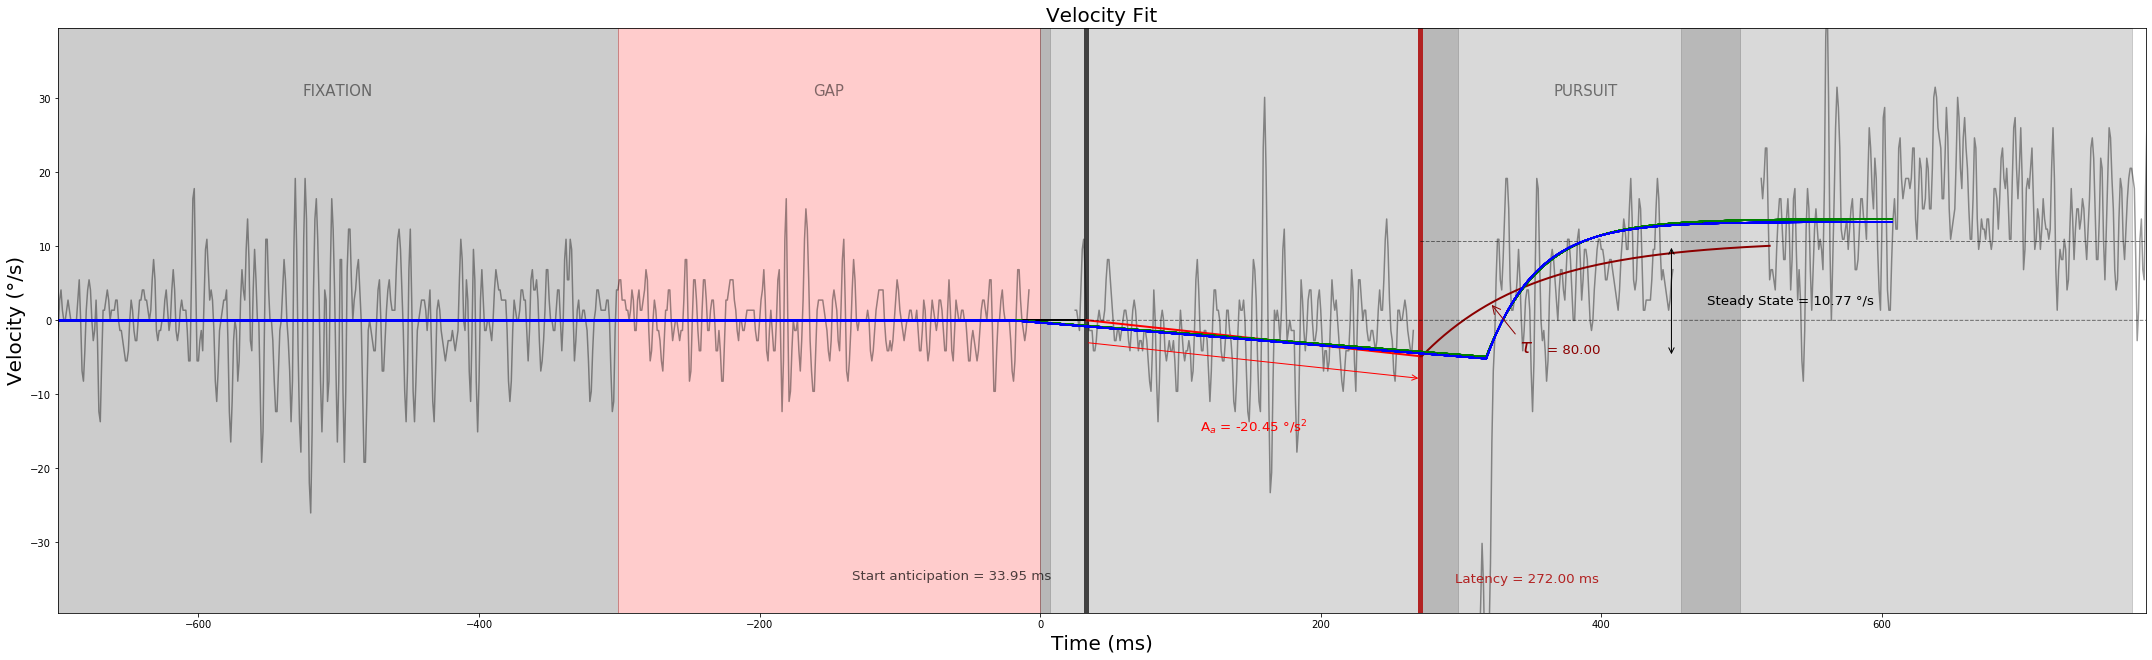

In [11]:
s, t = 11, 82
print(sujets[s])
result_full_data_s11_82, result_red_data_s11_82 = moulti_fit(s, t)

YK
[458.73587135 617.15038987 739.72964699 762.76077651 513.29859754
 657.95932911 573.38742705 765.10614244 646.82216731 595.33203717
 750.07196367 422.32133076 612.21034673 715.43845268 450.47580767
 490.49478663 468.64893651 671.37521363 796.5548245  470.08484332
 504.4911264  584.56599048 687.66815201 478.17327699 701.36663488]
[457.73587135 616.15038987 738.72964699 761.76077651 512.29859754
 656.95932911 572.38742705 764.10614244 645.82216731 594.33203717
 749.07196367 421.32133076 611.21034673 714.43845268 449.47580767
 489.49478663 467.64893651 670.37521363 795.5548245  469.08484332
 503.4911264  583.56599048 686.66815201 477.17327699 700.36663488]


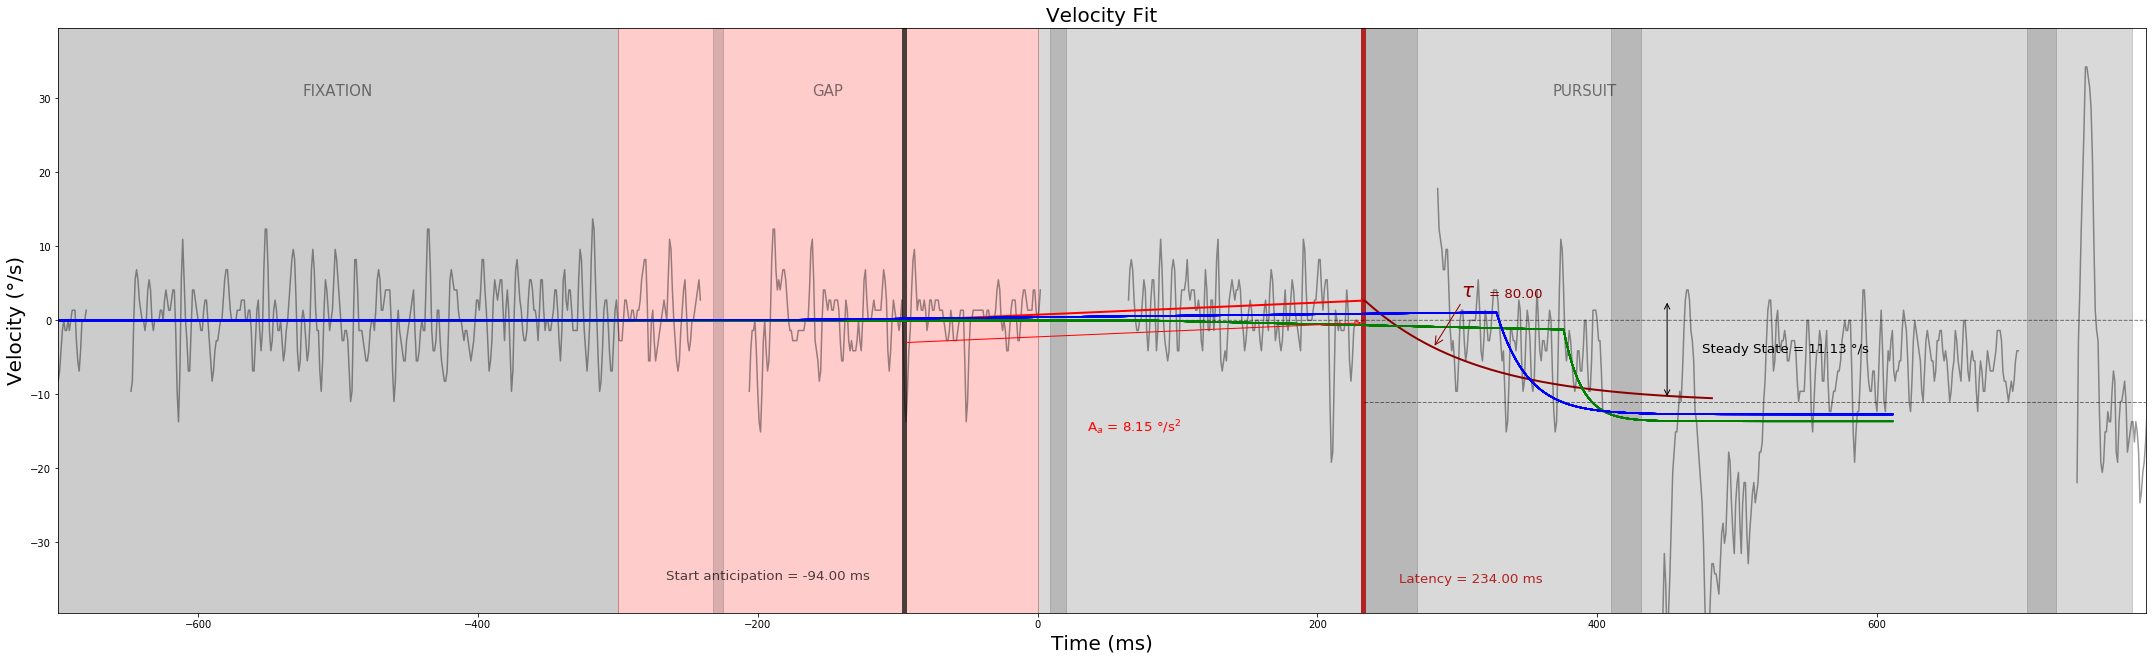

In [12]:
s, t = 11, 190
print(sujets[s])
result_full_data_s11_190, result_red_data_s11_190 = moulti_fit(s, t)

YK
[579.73587135 738.15038987 860.72964699 883.76077651 634.29859754
 778.95932911 694.38742705 886.10614244 767.82216731 716.33203717
 871.07196367 543.32133076 733.21034673 836.43845268 571.47580767
 611.49478663 589.64893651 792.37521363 917.5548245  591.08484332
 625.4911264  705.56599048 808.66815201 599.17327699 822.36663488]
[579.73587135 738.15038987 860.72964699 883.76077651 634.29859754
 778.95932911 694.38742705 886.10614244 767.82216731 716.33203717
 871.07196367 543.32133076 733.21034673 836.43845268 571.47580767
 611.49478663 589.64893651 792.37521363 917.5548245  591.08484332
 625.4911264  705.56599048 808.66815201 599.17327699 822.36663488]


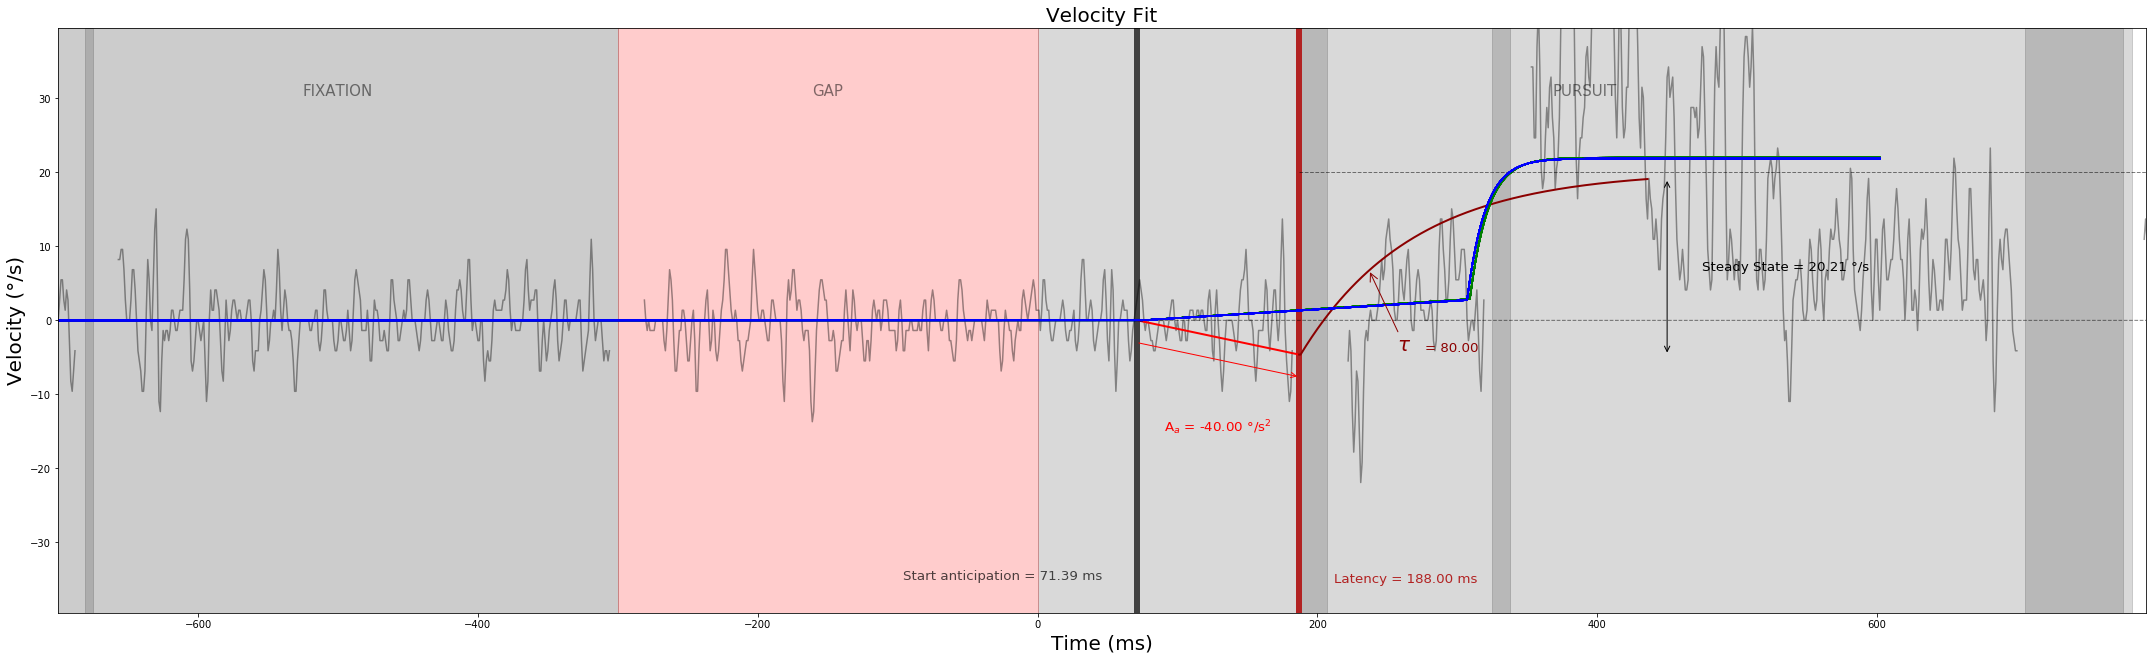

In [13]:
s, t = 11, 191
print(sujets[s])
result_full_data_s11_191, result_red_data_s11_191 = moulti_fit(s, t)

# Hist

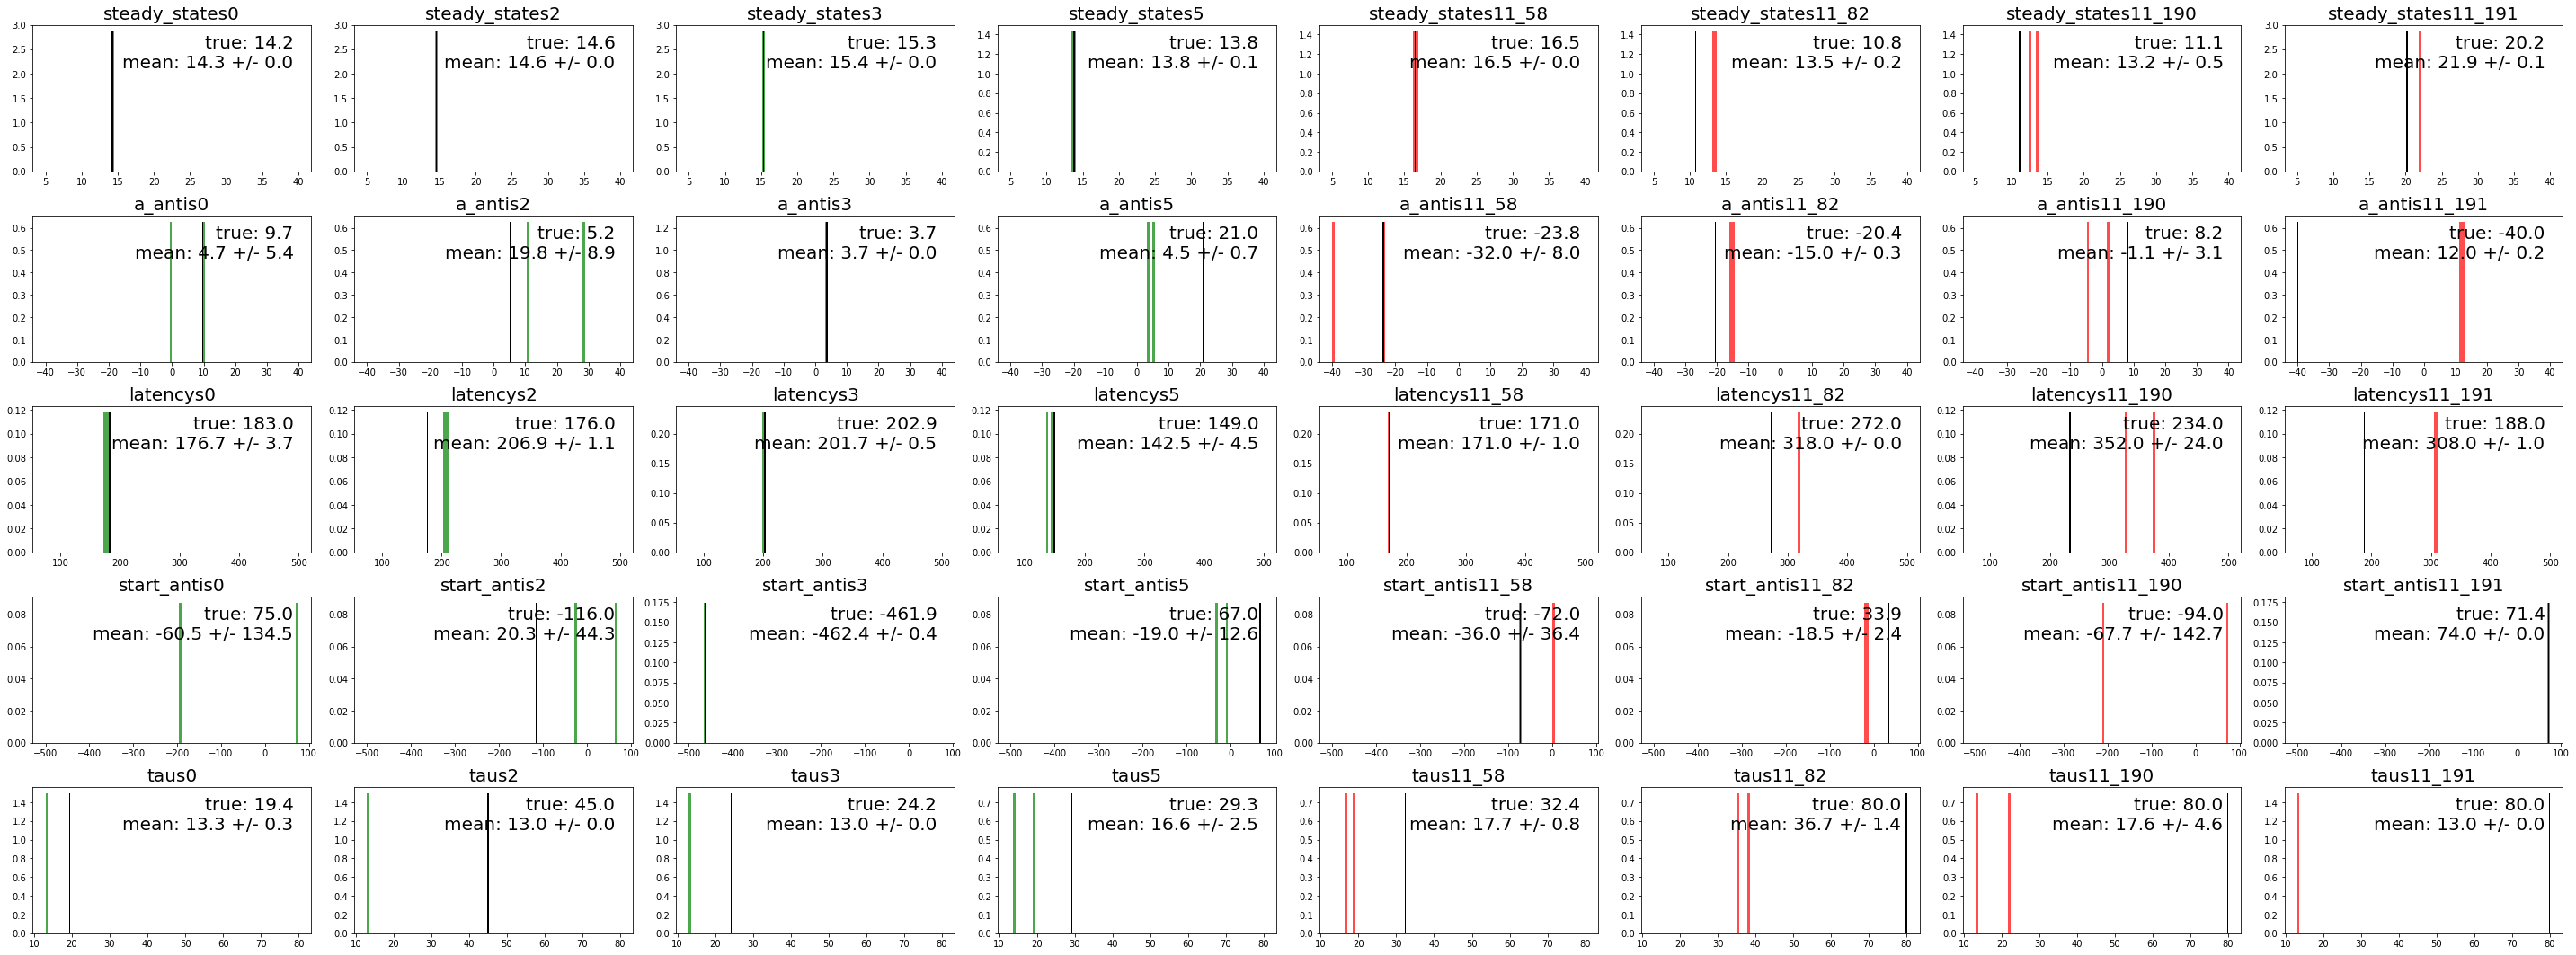

In [14]:
histoto([result_full_data_s0, result_full_data_s2, result_full_data_s3, result_full_data_s5,
         result_full_data_s11_58, result_full_data_s11_82, result_full_data_s11_190, result_full_data_s11_191],
        [result_red_data_s0, result_red_data_s2, result_red_data_s3, result_red_data_s5,
         result_red_data_s11_58, result_red_data_s11_82, result_red_data_s11_190,result_red_data_s11_191],
        ['s0', 's2', 's3', 's5', 's11_58', 's11_82', 's11_190', 's11_191'],
        [ 'g',  'g',  'g',  'g',      'r',      'r',       'r',       'r'], bins=100)